In [1]:
import numpy as np
import tensorflow as tf
import struct
import matplotlib.pyplot as plt

#### Function to read idx files:

In [2]:
def read_idx(filename):
    with open(filename, 'rb') as f:
        zero, data_type, dims = struct.unpack('>HBB', f.read(4))
        shape = tuple(struct.unpack('>I', f.read(4))[0] for d in range(dims))
        return np.frombuffer(f.read(), dtype=np.uint8).reshape(shape)

#### Read the training/validation datasets:

In [3]:
training_data = read_idx('./MNIST/train-images.idx3-ubyte')
training_labels = read_idx('./MNIST/train-labels.idx1-ubyte')
validation_data = read_idx('./MNIST/t10k-images.idx3-ubyte')
validation_labels = read_idx('./MNIST/t10k-labels.idx1-ubyte')

#### Show some data

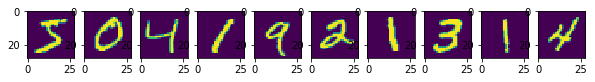

In [4]:
fig, ax = plt.subplots(1,10,figsize=(10,10))
for i in range(10): 
    ax[i].imshow(training_data[i])


### Create the tf-Dataset

In [5]:
tf.reset_default_graph()

In [6]:
training_dataset = tf.data.Dataset.from_tensor_slices((training_data, training_labels))
validation_dataset = tf.data.Dataset.from_tensor_slices((validation_data, validation_labels))

In [7]:
# use fixed batch size of 128 for training
training_batch_size = 128

# always use complete validation dataset
validation_batch_size = 10000

training_dataset = training_dataset.batch(training_batch_size)
validation_dataset = validation_dataset.batch(validation_batch_size)

# shuffle dataset so we always train in a drifferent order
training_dataset = training_dataset.shuffle(buffer_size=4, reshuffle_each_iteration=True)

### Iterator

In [8]:
iterator = tf.data.Iterator.from_structure(training_dataset.output_types,
                                           training_dataset.output_shapes)
next_batch = iterator.get_next()
training_init_op = iterator.make_initializer(training_dataset)
validation_init_op = iterator.make_initializer(validation_dataset)

### Model

In [9]:
input_data = next_batch[0]
labels = next_batch[1]

input_data = tf.reshape(input_data,shape=[-1,784])
input_data=tf.cast(input_data,tf.float32)
one_hot_lalbels = tf.one_hot(labels,10)



### Forward step

In [10]:
weights = tf.Variable(tf.random_normal( shape=[28 * 28, 10], stddev=2e-06))
biases = tf.Variable(tf.zeros(shape=[10]))
drive = input_data @ weights
drive = drive + biases
output = tf.nn.softmax(drive)

### Metrics

In [11]:
cross_entropy = tf.nn.softmax_cross_entropy_with_logits_v2(logits=drive, labels=one_hot_lalbels)
loss = tf.reduce_mean(cross_entropy)
correct_prediction = tf.equal(tf.argmax(output, axis=1), tf.cast(labels,tf.int64) )
accuracy           = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

### Optimizer

In [12]:
optimizer          = tf.train.AdamOptimizer(learning_rate = 1e-5,)
training_step      = optimizer.minimize(loss)

### Summaries

In [13]:
tf.summary.scalar('loss', loss)
tf.summary.scalar('acc', accuracy)
merged_summaries = tf.summary.merge_all()
# use small flush_secs to make sure data is saved
train_writer = tf.summary.FileWriter('./summaries/train/',flush_secs=2)
validation_writer = tf.summary.FileWriter('./summaries/validation/',flush_secs=0.1)


### Training

In [14]:
epochs = 5

saver = tf.train.Saver()

with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    global_step = 0
    best_acc = 0
    for ep in range(epochs):
        # TRAINING
        # Load the training data into the iterator.
        sess.run(training_init_op)
        # In each epoch we want to go through all batches of the training data. 
        #print('epoch: ' + str(ep))
        while True:
            try:
                # read out the summary.
                _, summary  = sess.run((training_step, merged_summaries))
                # We write the summary into our folder.
                train_writer.add_summary(summary, global_step)
                # Update the step counter.
                global_step += 1

            # Breakout of the loop if we looked at all batches
            except tf.errors.OutOfRangeError:
                break
        
        #Validate with current training progress
        sess.run(validation_init_op)
        result = sess.run([merged_summaries, accuracy])
        summary = result[0]
        acc = result[1]
        
        # save best data
        if acc > best_acc:
            save_path = "./best_data-mnist.ckpt"
            best_acc = acc
            saver.save(sess, save_path)
            print('saving checkpoint for epoch {} with acc.: {} at: {}'.format(ep,acc, save_path))
 
        validation_writer.add_summary(summary, global_step)



saving checkpoint for epoch 0 with acc.: 0.9110000133514404 at: ./best_data-mnist.ckpt
saving checkpoint for epoch 1 with acc.: 0.9182000160217285 at: ./best_data-mnist.ckpt
saving checkpoint for epoch 2 with acc.: 0.9217000007629395 at: ./best_data-mnist.ckpt
saving checkpoint for epoch 3 with acc.: 0.9239000082015991 at: ./best_data-mnist.ckpt
saving checkpoint for epoch 4 with acc.: 0.9240000247955322 at: ./best_data-mnist.ckpt


### Load checkpoint and test a image

In [15]:
image_id = 50
your_image = validation_data[image_id]
your_image=np.reshape(your_image,(784))
loader = tf.train.Saver()

with tf.Session() as sess:
    loader.restore(sess, "./best_data-mnist.ckpt")
    
    
    #sess.run(tf.global_variables_initializer())

    pred = sess.run(output,feed_dict={input_data: [your_image]})[0]
    pred = np.argmax(pred)
    print('original label: {} , prediction: {} '.format(validation_labels[image_id], pred))

INFO:tensorflow:Restoring parameters from ./best_data-mnist.ckpt
original label: 6 , prediction: 6 
